In [1]:
from data_utils import *
from helpers import *
from sketch_transfer import *
from model_1enc import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def load_model(enc, dec, hp):
    model = SketchTransfer_enc_dec(hp)
    saved_enc = torch.load(enc)
    saved_dec = torch.load(dec)
    model.encoder.load_state_dict(saved_enc)
    model.decoder.load_state_dict(saved_dec)
    return model

458896: Nmax=100, small data, wKL=0.001, seperation OK
951006: Nmax=100, small data, wKL=0.01, very good seperation
676178: Nmax=100, full data guided5, wKL=0.01, 2 latent dim, probably need higher dim, 700 epochs, interval=3

In [11]:
hp = HParams()
hp.enc_hidden_size = 256  # 256
hp.dec_hidden_size = 512  # 512
hp.Nmax = 100
hp.save_every = 100
hp.wKL = 0.001
hp.KL_start = 0.01
hp.KL_delta = 0.003
hp.KL_min = 0.0
hp.lr = 0.001
hp.lr_decay = 0.999
hp.style_dim = 5
hp.Nz = 2   # latent dimension
hp.Nz_dec = hp.Nz # 1 encoder, 1 decoder
hp.M = 3 # gaussian mixture

model = load_model("models/0204/sketch_encoder_sel_0.085308_epoch_1100.pth",
                                  "models/0204/sketch_decoder_sel_0.085308_epoch_1100.pth", hp)
#dataset = ControlRelative("data/guided5.csv", n_styles=5, seg_len=hp.Nmax, window=70, smooth_iterations=3, cutoff=(0,50), small_data=True)
dataset = ControlRelative("data/line5.csv", n_styles=5, seg_len=hp.Nmax, window=100, smooth_iterations=5, cutoff=(10,50))
model.encoder.train(False)
model.decoder.train(False)

Loaded 184 segments of style 0
Shape: (184, 2, 100)
Loaded 206 segments of style 1
Shape: (206, 2, 100)
Loaded 205 segments of style 2
Shape: (205, 2, 100)
Loaded 216 segments of style 3
Shape: (216, 2, 100)
Loaded 198 segments of style 4
Shape: (198, 2, 100)


LSTMDecoder(
  (fc_hc): Linear(in_features=7, out_features=1024, bias=True)
  (lstm): LSTM(9, 512)
  (fc_params): Linear(in_features=512, out_features=18, bias=True)
)

Length =  683


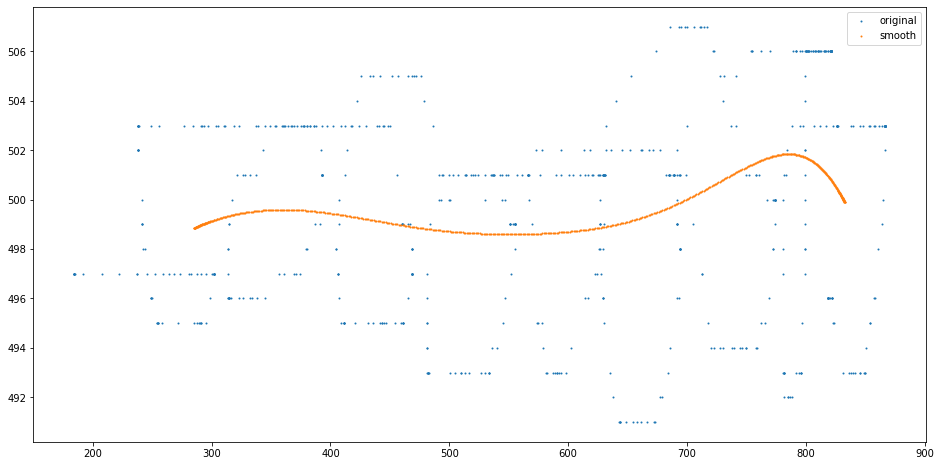

In [178]:
plt.figure(figsize=(16,8))
dataset.visualize_original(1,0)

Encoded style:  [0. 0. 1. 0. 0.]


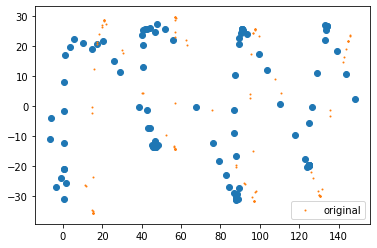

In [10]:
model.hp.temperature = 0.5
idx = 480
data, style = dataset[idx]
inputs = torch.FloatTensor(data).cuda().unsqueeze(0).permute(2, 0, 1)
labels = torch.FloatTensor(style).cuda().unsqueeze(0)
_, __, x, y = model.test_reconstruction(inputs, labels)
N = len(x)
control_x = np.array([i for i in range(N)]) * 1.5
x = control_x + x
plt.scatter(x, y)
dataset.visualize(idx)

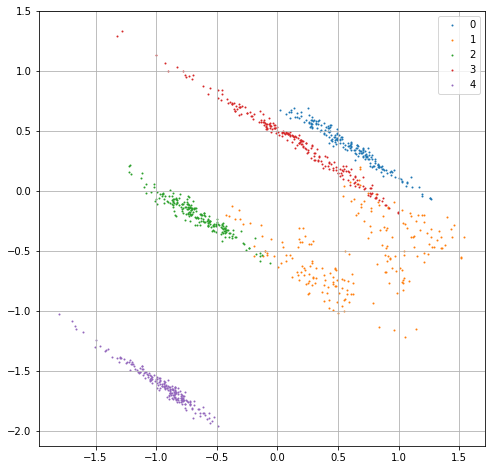

In [12]:
def scatter_latent(dataset, style, color):
    x1 = []
    x2 = []
    #x3 = []
    #x4 = []
    for i in range(len(dataset)):
        data, labels = dataset[i]
        if labels[style] < 0.5:
            continue
        inputs = torch.FloatTensor(data[:2, :]).cuda().unsqueeze(0).permute(2, 0, 1)
        labels = torch.FloatTensor(labels).cuda().unsqueeze(0)

        model.encoder.train(False)
        z, mu, sigma_hat = model.encoder(inputs, labels)
        z = z.squeeze().detach().cpu().numpy()
        x1.append(z[0])
        x2.append(z[1])
        #x3.append(z[2])
        #x4.append(z[3])
    #plt.subplot(121)
    plt.scatter(x1, x2, s=1, c=color, label=str(style))
    #plt.subplot(122)
    #plt.scatter(x3, x4, s=1, c=color)
    
plt.figure(figsize=(8,8))
plt.grid(True)
scatter_latent(dataset, 0, '#1f77b4')
scatter_latent(dataset, 1, '#ff7f0e')
scatter_latent(dataset, 2, '#2ca02c')
scatter_latent(dataset, 3, '#d62728')
scatter_latent(dataset, 4, '#9467bd')
plt.legend()

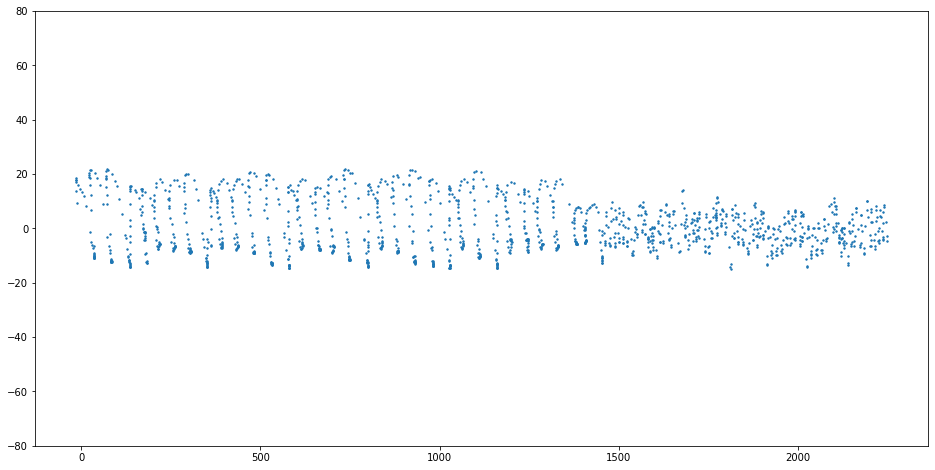

In [19]:
plt.figure(figsize=(16,8))
plt.ylim((-80, 80))
model.hp.temperature = 0.99
stroke_latent = torch.FloatTensor([[0.5, 0.5]]).cuda()
labels = torch.FloatTensor([[1, 0.1, 1, 0, 0]]).cuda()
N = 1500
_, __, x, y = model.generate_with_latent(stroke_latent, labels, steps=N)
control_x = np.array([i for i in range(N)]) * 1.5
x = control_x + x
plt.scatter(x, y, s=2)

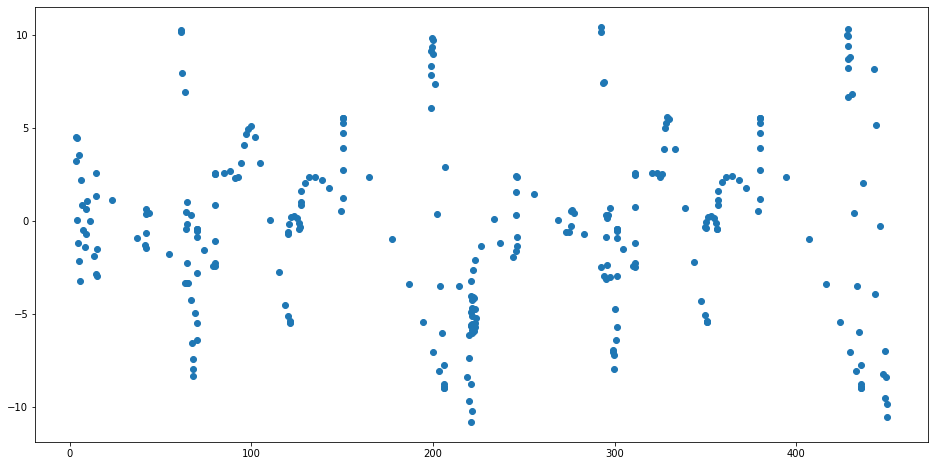

In [166]:
plt.figure(figsize=(16,8))
stroke_latent = torch.FloatTensor([[0.5,-1.65]]).cuda()
model.hp.temperature = 0.3
_, __, x, y = model.generate_with_latent(stroke_latent, steps=300)
N = len(x)
control_x = np.array([i for i in range(N)]) * 1.5
x = control_x + x
plt.scatter(x, y)

Length =  326


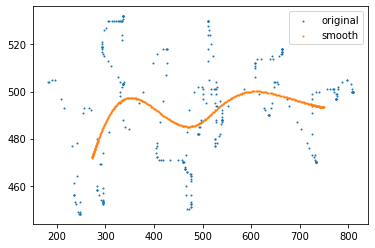

In [142]:
dataset.visualize_original(3,0)

In [49]:
def load_sketch_transfer_model(enc1, enc2, dec, hp):
    model = SketchTransfer_enc2(hp)
    saved_enc1 = torch.load(enc1)
    saved_enc2 = torch.load(enc2)
    saved_dec = torch.load(dec)
    model.encoder_control.load_state_dict(saved_enc1)
    model.encoder_stroke.load_state_dict(saved_enc2)
    model.decoder.load_state_dict(saved_dec)
    return model

In [67]:
hp = HParams()
hp.style_dim = 5
hp.Nz = 4   # latent dimension
hp.Nz_dec = 2 * hp.Nz
hp.M = 3 # gaussian mixture
model = load_sketch_transfer_model("models/0128/sketch_encoder_control_sel_0.840255_epoch_1400.pth", \
                                   "models/0128/sketch_encoder_stroke_sel_0.840255_epoch_1400.pth", \
                                  "models/0128/sketch_decoder_sel_0.840255_epoch_1400.pth", hp)
dataset = Guided("data/guided5.csv")
model.encoder_control.train(False)
model.encoder_stroke.train(False)
model.decoder.train(False)

Loaded 2561 segments of style 0
Shape: (2561, 4, 100)
Loaded 1822 segments of style 1
Shape: (1822, 4, 100)
Loaded 2634 segments of style 2
Shape: (2634, 4, 100)
Loaded 1443 segments of style 3
Shape: (1443, 4, 100)
Loaded 1181 segments of style 4
Shape: (1181, 4, 100)


LSTMDecoder(
  (fc_hc): Linear(in_features=8, out_features=256, bias=True)
  (lstm): LSTM(10, 128)
  (fc_params): Linear(in_features=128, out_features=18, bias=True)
)

Encoded style:  [0. 0. 0. 0. 1.]


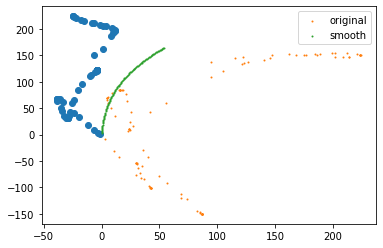

In [68]:
model.hp.temperature = 0.3
idx = 9580
data, style = dataset[idx]
inputs = torch.FloatTensor(data).cuda().unsqueeze(0).permute(2, 0, 1)
labels = torch.FloatTensor(style).cuda().unsqueeze(0)
xs, ys, dx, dy = model.test_reconstruction(inputs, labels)
plt.scatter(xs, ys)
dataset.visualize(idx)

In [57]:
def scatter_latent_control(dataset, style, color):
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    for i in range(len(dataset)):
        data, labels = dataset[i]
        if labels[style] < 0.5:
            continue
        inputs = torch.FloatTensor(data[2:, :]).cuda().unsqueeze(0).permute(2, 0, 1)
        labels = torch.FloatTensor(labels).cuda().unsqueeze(0)

        model.encoder_control.train(False)
        z, mu, sigma_hat = model.encoder_control(inputs)
        z = z.squeeze().detach().cpu().numpy()
        x1.append(z[0])
        x2.append(z[1])
        x3.append(z[2])
        x4.append(z[3])
    plt.subplot(121)
    plt.scatter(x1, x2, s=1, c=color)
    plt.subplot(122)
    plt.scatter(x3, x4, s=1, c=color)
    
def scatter_latent_control_test(dataset, style, color):
    x1 = []
    x2 = []
    for i in range(len(dataset)):
        data, labels = dataset[i]
        if labels[style] < 0.5:
            continue
        if data[2, 0] < 0:
            data[2, :] *= -1.0
        if data[3, 0] < 0:
            data[3, :] *= -1.0
        inputs = torch.FloatTensor(data[2:, :]).cuda().unsqueeze(0).permute(2, 0, 1)
        labels = torch.FloatTensor(labels).cuda().unsqueeze(0)

        model.encoder_control.train(False)
        z, mu, sigma_hat = model.encoder_control(inputs)
        z = z.squeeze().detach().cpu().numpy()
        x1.append(z[0])
        x2.append(z[1])
    plt.scatter(x1, x2, s=1, c=color)
    
def scatter_latent_stroke(dataset, style, color):
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    for i in range(len(dataset)):
        data, labels = dataset[i]
        if labels[style] < 0.5:
            continue
        inputs = torch.FloatTensor(data[:2, :]).cuda().unsqueeze(0).permute(2, 0, 1)
        labels = torch.FloatTensor(labels).cuda().unsqueeze(0)

        model.encoder_stroke.train(False)
        z, mu, sigma_hat = model.encoder_stroke(inputs, labels)
        z = z.squeeze().detach().cpu().numpy()
        x1.append(z[0])
        x2.append(z[1])
        x3.append(z[2])
        x4.append(z[3])
    plt.subplot(121)
    plt.scatter(x1, x2, s=1, c=color)
    plt.subplot(122)
    plt.scatter(x3, x4, s=1, c=color)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


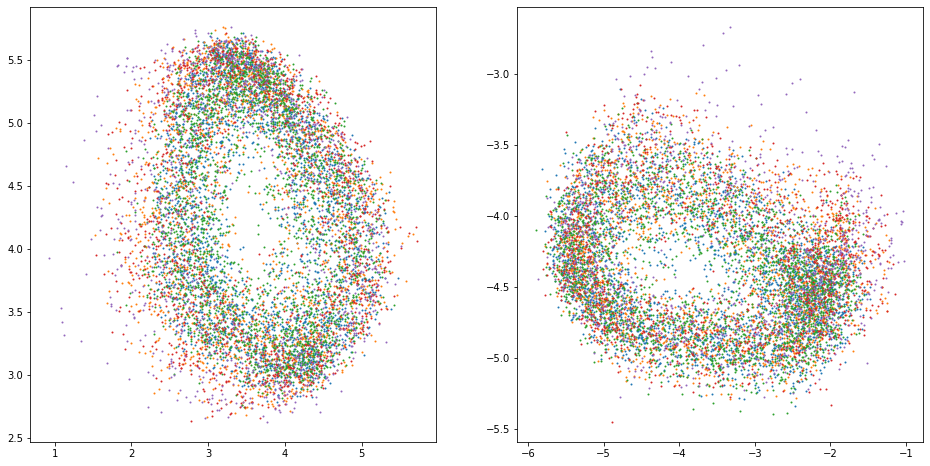

In [59]:
plt.figure(figsize=(16,8))
scatter_latent_control(dataset, 0, '#1f77b4')
scatter_latent_control(dataset, 1, '#ff7f0e')
scatter_latent_control(dataset, 2, '#2ca02c')
scatter_latent_control(dataset, 3, '#d62728')
scatter_latent_control(dataset, 4, '#9467bd')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


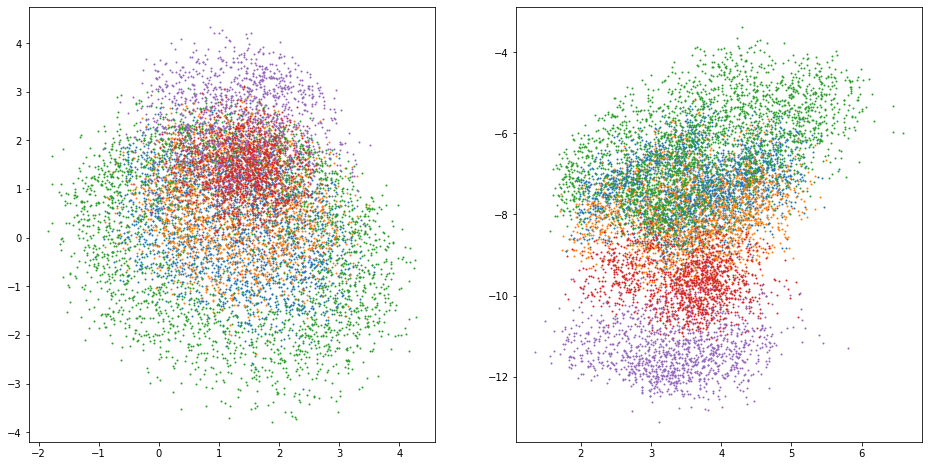

In [60]:
plt.figure(figsize=(16,8))
scatter_latent_stroke(dataset, 0, '#1f77b4')
scatter_latent_stroke(dataset, 1, '#ff7f0e')
scatter_latent_stroke(dataset, 2, '#2ca02c')
scatter_latent_stroke(dataset, 3, '#d62728')
scatter_latent_stroke(dataset, 4, '#9467bd')

In [3]:
model = load_sketch_transfer_model("sketch_encoder_control_sel_0.713441_epoch_780.pth", \
                                   "sketch_encoder_stroke_sel_0.713441_epoch_780.pth", \
                                  "sketch_decoder_sel_0.713441_epoch_780.pth")
model.encoder_control.train(False)
model.encoder_stroke.train(False)
model.decoder.train(False)

LSTMDecoder(
  (fc_hc): Linear(in_features=4, out_features=256, bias=True)
  (lstm): LSTM(6, 128)
  (fc_params): Linear(in_features=128, out_features=18, bias=True)
)

In [4]:
dataset = SmoothCurve("data/threecurves.csv")

Loaded 1715 segments of style 0
Shape: (1715, 4, 100)
Loaded 912 segments of style 1
Shape: (912, 4, 100)
Loaded 1469 segments of style 2
Shape: (1469, 4, 100)


Encoded style:  [0. 1. 0.]


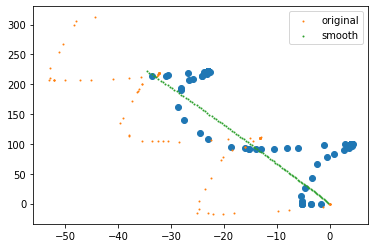

In [7]:
model.hp.temperature = 0.5
idx = 2190
data, style = dataset[idx]
inputs = torch.FloatTensor(data).cuda().unsqueeze(0).permute(2, 0, 1)
labels = torch.FloatTensor(style).cuda().unsqueeze(0)
xs, ys, dx, dy = model.test_reconstruction(inputs, labels)
plt.scatter(xs, ys)
dataset.visualize(idx)

In [8]:
def explore(zc1, zc2, zs1, zs2, t):
    plt.figure(figsize=(12, 12))
    colors = np.linspace(0.0, 1.0, 100)
    plt.cla()
    style_label = np.array([1.0, 0.0, 0.0])
    model.hp.temperature = t
    labels = torch.FloatTensor(style_label).cuda().unsqueeze(0)
            
    z_stroke = torch.FloatTensor([zs1, zs2]).cuda().unsqueeze(0)
    z_control = torch.FloatTensor([zc1, zc2]).cuda().unsqueeze(0)
    z = torch.cat((z_control, z_stroke), dim=1)

    sos = Variable(torch.Tensor([0.0, 0.0]).view(1,1,-1).cuda())
    s = sos
    seq_x = []
    seq_y = []
    hidden_cell = None
    for k in range(model.hp.Nmax):
        decoder_inputs = torch.cat([s, z.unsqueeze(0)], 2)

        # decode:
        model.pi, model.mu_x, model.mu_y, model.sigma_x, model.sigma_y, \
            model.rho_xy, hidden, cell = \
                model.decoder(decoder_inputs, z, None, hidden_cell)
        hidden_cell = (hidden, cell)
        s, dx, dy = model.sample_next_state(False)
        seq_x.append(dx)
        seq_y.append(dy)

    x_sample = np.cumsum(seq_x, 0)
    y_sample = np.cumsum(seq_y, 0)

    plt.scatter(x_sample, y_sample, s=1, c=colors)
    plt.ylim(-100, 100)
    plt.xlim(-100, 100)

In [14]:
def scatter_latent_control(dataset, style, color):
    x1 = []
    x2 = []
    for i in range(len(dataset)):
        data, labels = dataset[i]
        if labels[style] < 0.5:
            continue
        inputs = torch.FloatTensor(data[2:, :]).cuda().unsqueeze(0).permute(2, 0, 1)
        labels = torch.FloatTensor(labels).cuda().unsqueeze(0)

        model.encoder_control.train(False)
        z, mu, sigma_hat = model.encoder_control(inputs)
        z = z.squeeze().detach().cpu().numpy()
        x1.append(z[0])
        x2.append(z[1])
    plt.scatter(x1, x2, s=1, c=color)
    
def scatter_latent_control_test(dataset, style, color):
    x1 = []
    x2 = []
    for i in range(len(dataset)):
        data, labels = dataset[i]
        if labels[style] < 0.5:
            continue
        if data[2, 0] < 0:
            data[2, :] *= -1.0
        if data[3, 0] < 0:
            data[3, :] *= -1.0
        inputs = torch.FloatTensor(data[2:, :]).cuda().unsqueeze(0).permute(2, 0, 1)
        labels = torch.FloatTensor(labels).cuda().unsqueeze(0)

        model.encoder_control.train(False)
        z, mu, sigma_hat = model.encoder_control(inputs)
        z = z.squeeze().detach().cpu().numpy()
        x1.append(z[0])
        x2.append(z[1])
    plt.scatter(x1, x2, s=1, c=color)
    
def scatter_latent_stroke(dataset, style, color):
    x1 = []
    x2 = []
    for i in range(len(dataset)):
        data, labels = dataset[i]
        if labels[style] < 0.5:
            continue
        inputs = torch.FloatTensor(data[:2, :]).cuda().unsqueeze(0).permute(2, 0, 1)
        labels = torch.FloatTensor(labels).cuda().unsqueeze(0)

        model.encoder_stroke.train(False)
        z, mu, sigma_hat = model.encoder_stroke(inputs, labels)
        z = z.squeeze().detach().cpu().numpy()
        x1.append(z[0])
        x2.append(z[1])
    plt.scatter(x1, x2, s=1, c=color)

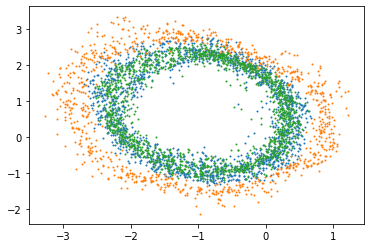

In [11]:
scatter_latent_control(dataset, 0, '#1f77b4')
scatter_latent_control(dataset, 1, '#ff7f0e')
scatter_latent_control(dataset, 2, '#2ca02c')

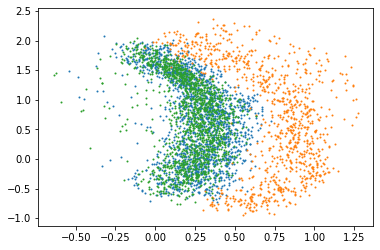

In [12]:
scatter_latent_control_test(dataset, 0, '#1f77b4')
scatter_latent_control_test(dataset, 1, '#ff7f0e')
scatter_latent_control_test(dataset, 2, '#2ca02c')

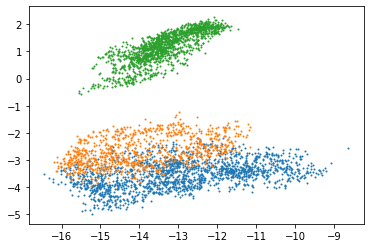

In [15]:
scatter_latent_stroke(dataset, 0, '#1f77b4')
scatter_latent_stroke(dataset, 1, '#ff7f0e')
scatter_latent_stroke(dataset, 2, '#2ca02c')

In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
wig = interactive(explore, zc1=widgets.FloatSlider(min=-3, max=1), \
                  zc2=widgets.FloatSlider(min=-1.5, max=1.5), \
                  zs1=widgets.FloatSlider(min=-16, max=-11), \
                  zs2=widgets.FloatSlider(min=-5, max=2), \
                  t=widgets.FloatSlider(min=0.02, max=1))
display(wig)

interactive(children=(FloatSlider(value=0.0, description='zc1', max=1.0, min=-3.0), FloatSlider(value=0.0, des…